# ENGG1003 Project

## Academic Honesty
I declare that the lab work here submitted is original
except for source material explicitly acknowledged,
and that the same or closely related material has not been
previously submitted for another course.
I also acknowledge that I am aware of University policy and
regulations on honesty in academic work, and of the disciplinary
guidelines and procedures applicable to breaches of such
policy and regulations, as contained in the website.

University Guideline on Academic Honesty:
https://www.cuhk.edu.hk/policy/academichonesty/

Student Name : Cheung Yik Fung

Student ID : 1155211679

Class/Section : ENGG1003EC

Date : 12-12-2023


## Project Description
After the pandemic, what happens to the Hong Kong Airport? How is the operation right now? Through this project, we will analyse the flight information of the Hong Kong Airport, to solve the following problems (which is the work I have done in this project):
1. What is the average / minimum / maximum / s.d. delay of the flights for the last 90 days?
2. What are the common destinations / origins of the flights?
3. Are longer routes generally have a longer delay?
4. Will flights arrived / departed at night have a longer delay?
5. Do longer routes have generally less flights?
6. What are the flight frequency in a day?

## Work Description
Please click the code blocks in order to use this smoothly. There is a `Fetcher` class for data fetching with `static` and `dynamic` mode (we will only use static mode in this project). `FlightIdentifier` and `Flight` are the classes to store a single flight information. `FlightAnalyser` is the base class for basic operations of data retrieval. `QuestionX` class indicates that the problem we want to investigate in. Please call the following if you want to run the questions individually for your personal interest:
```py
loop = asyncio.get_event_loop()
fa = QuestionX(loop, mode="static")
fa.solver(...) # put some parameters here if needed
fa.solverX(...) # if there are multiple solvers in a class, use this
```

## Used Modules
This projects uses `aiohttp` (for online data fetching), `aiofiles` (for asynchronous file IO), `matplotlib` (for data visualization), `pandas` (for using dataframe) and `cartopy` (for globe visualization)

This project also used some standard libraries such as `json` (for parsing JSON), `datetime` (for datetime processing) and `typing` (for using `Literal` type).

In [2]:
!pip install aiohttp matplotlib pandas cartopy aiofiles

In [3]:
import json
from datetime import *
import aiohttp
import aiofiles
from typing import Literal
import asyncio
import os

loop = asyncio.get_event_loop()

## Data Retrieval
Data are obtained through API (instead of a static `.csv` file). The request path is https://www.hongkongairport.com/flightinfo-rest/rest/flights/past?date=&lang=en&cargo=false&arrival=false. There are four (mandatory) parameters:
1. Date (string): the date request for the flights in `YYYY-MM-DD` format.
2. Arrival (boolean): `true` if requesting for arrival flights (a.k.a. inbounding flights), or `false` if requesting for departure flights (a.k.a. outbounding flights).
3. Cargo (boolean): `true` if requesting for cargo flights, or `false` if not. We won't go deep into cargo flights in this project, so `false` will always be set in this project.
4. Lang (string): language of the data (only `en`, `zh_HK` and `zh_CN` is available). For the convenienve of data analysis `en` will always be set in this project.

For all the flights, some useful data are provided, including:
1. `time`: the estimated arrival time.
2. `status`: the current status of the flight. We only care about its arrival time this time.
3. `flight`: the aircraft invovled in this route and time. Flight number `no` and airline code `airline` are provided in each aircraft.
4. `destination / origin`: the destination(s) / origin(s) of the aircraft provided in IATA airport code. If there are multiple destinations / origins, it comes from / goes to each airport accordingly.

For the sake of convenience, we only consider data from `2023-08-16` to `2023-11-14`. In other words, data will not be dynamically fetched.

To fetch data, a Fetcher class is implemented:

In [9]:
class Fetcher:
    url = "https://raw.githubusercontent.com/chemistrying/ENGG1003_project/main/{arrival}/{date}.json"
    session: aiohttp.ClientSession
    mode: Literal["static", "dynamic"]

    def __init__(self, loop, mode: Literal["static", "dynamic"] = "static"):
        self.session = aiohttp.ClientSession(loop=loop)
        self.mode = mode
        pass

    async def __static_fetch_arival(self, date):
        async with aiofiles.open(f"arrival\\{date.strftime('%Y-%m-%d')}.json", mode="r") as f:
            data = await f.read()
            return json.loads(data)

    async def __static_fetch_departure(self, date):
        async with aiofiles.open(f"departure\\{date.strftime('%Y-%m-%d')}.json", mode="r") as f:
            data = await f.read()
            return json.loads(data)

    async def __dynamic_fetch_arrival(self, date):
        async with self.session.get(self.url.format(date=date.strftime("%Y-%m-%d"), arrival="arrival")) as response:
            text = await response.text()
            return json.loads(text)

    async def __dynamic_fetch_departure(self, date):
        async with self.session.get(self.url.format(date=date.strftime("%Y-%m-%d"), arrival="departure")) as response:
            text = await response.text()
            return json.loads(text)

    async def fetch_arrival(self, date):
        """
            Returns flights that its estiamted arrival date is equal to this specific date
        """
        if self.mode == "static":
            res = await self.__static_fetch_arival(date)
            return res
        else:
            res = await self.__dynamic_fetch_arrival(date)
            return res

    async def fetch_departure(self, date):
        """
            Returns flights that its actual departure time or estimated departure time is equal to this specific date
        """
        if self.mode == "static":
            res = await self.__static_fetch_departure(date)
            return res
        else:
            res = await self.__dynamic_fetch_departure(date)
            return res

    async def fetch_airport_info(self):
        """
            Returns airport codes and its corresponding locations
        """
        import csv

        async with self.session.get("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv") as response:
            text = await response.text()
            country_mapping = [row for row in csv.DictReader(text.split('\n'))]
            country_mapping = dict(
                zip(
                    [row["alpha-2"] for row in country_mapping],
                    [row["name"] for row in country_mapping]
                )
            )

        async with self.session.get("https://raw.githubusercontent.com/datasets/airport-codes/master/data/airport-codes.csv") as response:
            text = await response.text()
            airport_location = [row for row in csv.DictReader(text.split('\r\n'))]


        airport_info = {}
        for row in airport_location:
            if row["iata_code"]:
                try:
                    airport_info[row["iata_code"]] = dict(row | {"name": country_mapping[row["iso_country"]]})
                except:
                    # Fallback code
                    # Ignore errors
                    airport_info[row["iata_code"]] = dict(row | {"name": None})
                    pass

        return airport_info

    async def close(self):
        await self.session.close()

And a Flight class is used for storing flights:

In [5]:
class FlightIdentifier:
    flight_number: str
    airline: str

    def __init__(self, flight_number, airline):
        self.flight_number = flight_number
        self.airline = airline

class Flight:
    arrival: bool # is this flight an arrival flight
    est_time: str # estimated arrival / departure time in ISO format
    act_time: str # actual arrival / departure time in ISO format
    airports: list[str] # list of airport(s) that the flight come from / go to
    flight_code: list[FlightIdentifier]

    def __init__(self, arrival: bool, est_time: str, act_time: str, airports: list[str], flight_code: list[FlightIdentifier]):
        self.arrival = arrival
        self.est_time = est_time # need to use ISO 8601 here
        self.act_time = act_time # same as above
        self.airports = airports
        self.flight_code = [FlightIdentifier(x["no"], x["airline"]) for x in flight_code]

    """
        Some operator overloading magic down here
    """

    def __lt__(self, other):
        return datetime.fromisoformat(self.act_time) < datetime.fromisoformat(other.act_time)

    def __eq__(self, other):
        return self.__dict__ == other.__dict__

    def __hash__(self):
        """
            This hash function is meant to be used for storing things in a set
        """
        return hash((self.arrival, self.est_time, self.act_time, '-'.join(self.airports), ';'.join([fc.flight_number for fc in self.flight_code])))

In [ ]:
import os

class CustomEncoder(json.JSONEncoder):
    def default(self, o):
        return o.__dict__
    
if not os.path.isdir("arrival"):
    os.mkdir("arrival")
if not os.path.isdir("departure"):
    os.mkdir("departure")

today = date(2023, 11, 15)
client = Fetcher(loop, 'dynamic')
for i in range(1, 91):
    require_date = today - timedelta(i)
    
    arrival_data = await client.fetch_arrival(require_date)
    departure_data = await client.fetch_departure(require_date)
    with open(f"arrival\\{require_date.strftime('%Y-%m-%d')}.json", "w") as f:
        json.dump(arrival_data, f, indent=4, cls=CustomEncoder)
    
    with open(f"departure\\{require_date.strftime('%Y-%m-%d')}.json", "w") as f:
        json.dump(departure_data, f, indent=4, cls=CustomEncoder)

client.close()

## Data Processing
Having API seems to make data processing easier, but actually not: though it gives JSON data, the data content is somewhat more likely to be read by humans instead of machines. Here is an abstract of the return data (i.e.: contents in the "list"):
```json
{
    "time": "23:20",
    "flight": [
        {
            "no": "UO 703",
            "airline": "HKE"
        }
    ],
    "status": "At gate 00:48 (28/10/2023)",
    "statusCode": null,
    "origin": [
        "BKK"
    ],
    ... (omitted not used data here)
}
```
`status` provides the actual arrival time and `time` provides the estimated arrival time. Here, the actual arrival time is not quite convenient to deal with: it has to split the actual status of the flight and arrival time separately, and it is necessary to determine the date of the estimated time since the API returns flights with estimated arrival date before the query date.

The aforementioned property also gives us another problem: if we query two consecutive dates, repeated data will be returned on each API call.

Therefore, the below class `FlightAnalyser` handles all the data processing issues arised.

In [25]:
class FlightAnalyser:
    interval: int # The interval to be checked
    timezone: int # offset from utc
    client: Fetcher
    fixed_date: datetime = datetime(2023, 11, 14, 23, 59, 59, 0, timezone(timedelta(hours=8)))

    def __init__(self, loop, mode: Literal["static", "dynamic"] = "static"):
        self.client = Fetcher(loop, mode)

    def correct_data(self, delays, constant):
        """
            Correct the data by removing absoulted values larger than constant * s.d.
        """
        from statistics import stdev
        res = []
        sd = stdev(delays)
        for data in delays:
            if -constant * sd <= data and data <= constant * sd:
                res.append(data)
        return res

    def calculate_distance(self, src, dest):
        """
            Calculate distance between two places using longitude and latitude
        """
        # Approximate radius of earth in km
        r = 6373.0

        from math import sin, cos, sqrt, asin, radians
        src_lat, src_lon = list(map(lambda v: radians(float(v)), src.split(", ")))
        dest_lat, dest_lon = list(map(lambda v: radians(float(v)), dest.split(", ")))

        dlat = dest_lat - src_lat
        dlon = dest_lon - src_lon

        return 2 * r * asin(sqrt(pow(sin(dlat / 2), 2) + cos(src_lat) * cos(dest_lat) * pow(sin(dlon / 2), 2)))

    async def fetch_arrival(self, interval: int, tz=8) -> list[Flight]:
        """
            Fetches arrival flights and organize the data obtained
        """
        # only check flights between lower bound and upper bound
        # only returns flights which have arrived
        flights = set()
        today = self.fixed_date if self.client.mode == "static" else datetime.now(timezone(timedelta(hours=tz)))
        lower_bound = today - timedelta(days=interval)
        upper_bound = today
        for curr_date in [lower_bound.date() + timedelta(days=i) for i in range(interval + 1)]:
            # obtain data from api
            data = await self.client.fetch_arrival(curr_date)
            for datum in data:
                # ignore data which its date does not match query date - those data should have been obtained from previous queries
                if datum["date"] != curr_date.isoformat():
                    continue

                # iterate each flight group
                for group in datum["list"]:
                    # construct the estimated time (no date)
                    est_time = datetime.fromisoformat(f"{curr_date}T{group['time']}:00+08:00")

                    # tokenize the status
                    status_code = group["status"].split()

                    # only consider data with status "At gate"
                    if len(status_code) >= 3 and status_code[0] + ' ' + status_code[1] == "At gate":
                        # ok
                        if len(status_code) == 4:
                            # special case: the estimated time and actual time lies on different date
                            # need extract the date from the status code
                            temp_date = list(map(int, status_code[-1][1:-1].split('/')))
                            required_date = date(temp_date[2], temp_date[1], temp_date[0]) # this converts the date string given to date object

                            # construct the actual datetime
                            act_time = datetime.fromisoformat(f"{required_date}T{status_code[2]}:00+08:00")
                        else:
                            # both datetime lies on the same date - less work to handle
                            act_time = datetime.fromisoformat(f"{curr_date}T{status_code[2]}:00+08:00")

                        # determine if the time actually lies on the interval we are searching
                        if lower_bound <= act_time and act_time <= upper_bound:
                            # add to the entry
                            flights.add(Flight(True, est_time.isoformat(), act_time.isoformat(), group["origin"], group["flight"]))

        # sort the flights in actual arrival time chornological order
        flights = sorted(list(flights))
        return flights

    async def fetch_departure(self, interval: int, tz=8) -> list[Flight]:
        """
            Fetches departure flights and organize the data obtained
        """
        # only check flights between lower bound and upper bound
        # only returns flights which have departed
        # code is similar to analyse_arrival but with slight changes on cleansing data part
        flights = set()
        today = self.fixed_date if self.client.mode == "static" else datetime.now(timezone(timedelta(hours=tz)))
        lower_bound = today - timedelta(days=interval)
        upper_bound = today
        for curr_date in [lower_bound.date() + timedelta(days=i) for i in range(interval + 1)]:
            # obtain data from api
            data = await self.client.fetch_departure(curr_date)
            for datum in data:
                if datum["date"] != curr_date.isoformat():
                    continue

                for group in datum["list"]:
                    est_time = datetime.fromisoformat(f"{curr_date}T{group['time']}:00+08:00")

                    status_code = group["status"].split()

                    # only consider data with status "Dep"
                    # print(status_code)
                    if len(status_code) >= 2 and status_code[0] == "Dep":
                        # ok
                        if len(status_code) == 3:
                            # cleanse the date to ISO format
                            temp_date = list(map(int, status_code[-1][1:-1].split('/')))
                            required_date = date(temp_date[2], temp_date[1], temp_date[0])

                            act_time = datetime.fromisoformat(f"{required_date}T{status_code[1]}:00+08:00")
                        else:
                            act_time = datetime.fromisoformat(f"{curr_date}T{status_code[1]}:00+08:00")

                        if (lower_bound <= act_time and act_time <= upper_bound) or self.client.mode == "static": # ignore date bounding when in static mode
                            # add to the entry
                            flights.add(Flight(False, est_time.isoformat(), act_time.isoformat(), group["destination"], group["flight"]))

        flights = sorted(list(flights))
        return flights

    async def finish(self):
        await self.client.close()

## Question 1: What are the statistics of delays of the flights?
After obtaining the flights, we can do a quick summarization by obtaining mean, median, mode, standard deviation, minimum and maximum.


### Analysing Process
1. Obtain the flights data and calculate the corresponding delays.
2. Calculate the statistics needed using module `statistics`.

In [30]:
class Question1(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver1(self, interval: int = 90, arrival: bool = True):
        """
            Problem: What are the statistics of delays of the flights for the last 90 days?

            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        from statistics import mean, median, mode, stdev
        import pandas as pd

        # fetch data
        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        # calculate the delays of the flights in minutes
        delays = [int((datetime.fromisoformat(flight.act_time) - datetime.fromisoformat(flight.est_time)).total_seconds() // 60) for flight in flights]

        print(f"\rStatistics for Delays of {'Arrival' if arrival else 'Departure'} Flights")

        df = pd.DataFrame(
            {
                "Statistics": ["Mean", "Median", "Mode", "S.D.", "Min", "Max"],
                "Values": [mean(delays), median(delays), mode(delays), stdev(delays), min(delays), max(delays)]
            }
        )

        print(df)

    async def solver2(self, interval: int = 90, arrival: bool = True):
        """
            Problem: Output the diagram of the data.

            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        import matplotlib.pyplot as plt

        # fetch data
        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        # calculate the delays of the flights in minutes
        delays = [int((datetime.fromisoformat(flight.act_time) - datetime.fromisoformat(flight.est_time)).total_seconds() // 60) for flight in flights]

        counter = {}
        for idx in range(min(delays), max(delays) + 1):
            counter[idx] = 0

        for delay in delays:
            counter[delay] += 1

        plt.bar(list(range(min(delays), max(delays) + 1)), list(counter.values()))

        plt.title(f"{'Arrival' if arrival else 'Departure'} Flight Delay Distribution")
        plt.xlabel("Delay (in minutes)")
        plt.ylabel("Count")

    async def solver3(self, interval: int = 90, arrival: bool = True, bin_size: int = 5):
        """
            What if the data are binned?
            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        import matplotlib.pyplot as plt
        import numpy as np

        # fetch data
        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        # calculate the delays of the flights in minutes
        delays = [int((datetime.fromisoformat(flight.act_time) - datetime.fromisoformat(flight.est_time)).total_seconds() // 60) for flight in flights]

        delays = self.correct_data(delays, 10)

        lb, rb = min(delays), max(delays)

        counts, bins = np.histogram(delays, list(range(lb, rb + bin_size, bin_size)))

        plt.hist(bins[:-1], bins, weights=counts)

        plt.title(f"{'Arrival' if arrival else 'Departure'} Flight Delay Distribution (Binned)")
        plt.xlabel("Delay (in minutes)")
        plt.ylabel("Count")

In [31]:
fa = Question1(loop)
await fa.solver1(arrival=True)
print()
await fa.solver1(arrival=False)

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78643cc54b50>


Statistics for Delays of Arrival Flights
  Statistics       Values
0       Mean     6.887690
1     Median    -2.000000
2       Mode    -7.000000
3       S.D.    70.125647
4        Min  -364.000000
5        Max  3129.000000

Statistics for Delays of Departure Flights
  Statistics       Values
0       Mean    15.068854
1     Median     6.000000
2       Mode     1.000000
3       S.D.    52.229707
4        Min  -465.000000
5        Max  1639.000000


### Mini-conclusion
1. Mean is around 6.89 minutes and 15.1 minutes (corrected to 3 siginificant figures), which is slightly higher than expectation (imagine having an average delay of 15 minutes per flight!).
2. Both arrival and departure has a lesser median than mean. This signals that there are some flights with huge delay that pulls the mean up, while most of the data clusters in the middle.
3. Mode is surprisingly lower than 0 in arrival flights (-7 minutes) and 1 minute delay in departure flights.
4. Standard deviation is quite low and not spread out, compare with the minimum / maximum.

### Diagrams
These diagrams showcases the above conclusions.
If the data are binned, we can see the results more clearly. Note that for binned data, we can see that departure flights have less early departures but arrival flights have more early arrivals.

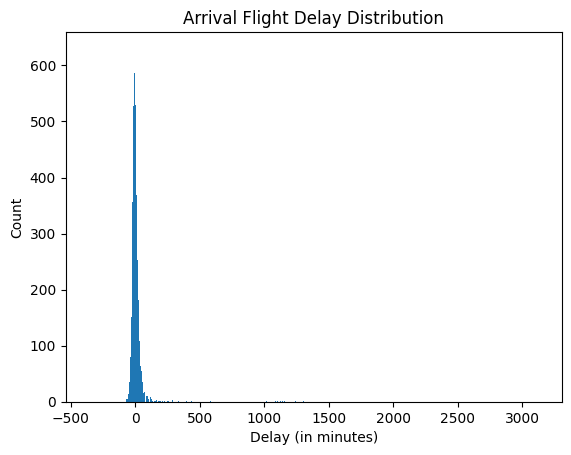

In [32]:
await fa.solver2(arrival=True)

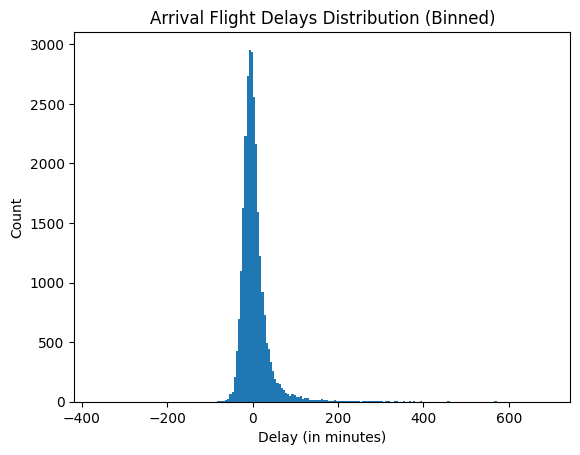

In [33]:
await fa.solver3(arrival=True)

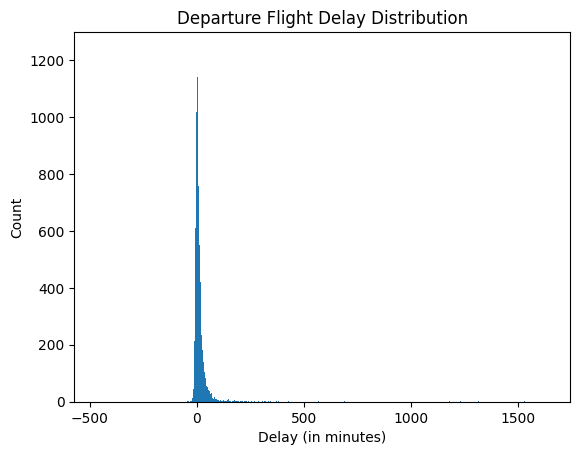

In [34]:
await fa.solver2(arrival=False)

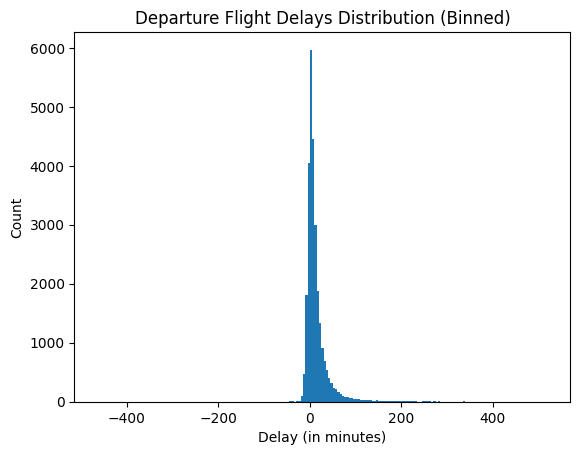

In [36]:
await fa.solver3(arrival=False)

### Suggestions
We notice that there are larger delays in departure flights than arrival flights. This means Hong Kong aviation industry has not be fully revived. How can we decrease the departure flights delays? Is it possible to train more people to join the aviation industry, or possibly invite people who quitted aviation industry during the pandemic to come back? Some work must be done by the government in order to decrease depature delay, and try to get arrival flights delay and departure flights delay as close as possible.

## Question 2a: What are the most common destinations of the flights?
By using the destination / origins info given by the data, we can analyse the common destinations / origins of the flights, thus analysing how frequent the flights between each countries are. We will visualize the data with heatmaps.



### Analysis Process
1. Obtain the flight data.
2. Count the number of flights that go to the specific destination and map to its corresponding belonging country.
3. Visualize the data through world heat map. The value of each country lies in the range $[0.0, 1.0]$, and is determined by the count of flights divded by maximum of count of flights amongst all countries. The values are quantized by bins of size $0.1$.



In [42]:
class Question2(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver1(self, interval: int = 90, arrival: bool = True):
        """
            Problem: What are the common destination / origin of flights for the past 90 days?

            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        import cartopy.crs as ccrs
        import cartopy.io.shapereader as shpreader
        import cartopy.feature as cf
        import matplotlib.pyplot as plt
        import matplotlib as mpl

        cmap = mpl.colormaps.get_cmap('tab20')

        airport_info = await self.client.fetch_airport_info()

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        ax = plt.axes(projection=ccrs.PlateCarree())
        countries_shp = shpreader.natural_earth(resolution='10m',
                                            category='cultural', name='admin_0_countries')
        special_regions_shp = shpreader.natural_earth(resolution='10m',
                                                      category='cultural', name='admin_0_map_units')
        taiwan_shp = shpreader.natural_earth(resolution='10m',
                                                      category='cultural', name='admin_0_disputed_areas')

        country_counter = dict.fromkeys(
            list(map(lambda v: v.attributes['WB_A2'], shpreader.Reader(countries_shp).records())) +
            list(map(lambda v: v.attributes['WB_A2'], shpreader.Reader(special_regions_shp).records())) + ['TW'],
            0
        )

        # Mark down the flight origin / destination
        for flight in flights:
            destinations = flight.airports
            for dest in destinations:
                # this is the country that the airport belongs to: airport_info[dest]["name"]
                country_counter[airport_info[dest]["iso_country"]] += 1

        maximo = max(country_counter.values())

        visited = dict.fromkeys(
            list(map(lambda v: v.attributes['WB_A2'], shpreader.Reader(countries_shp).records())) +
            list(map(lambda v: v.attributes['WB_A2'], shpreader.Reader(special_regions_shp).records())) + ['TW'],
            False
        )

        # Loop normal countries
        for country in shpreader.Reader(countries_shp).records():
            nome = country.attributes['WB_A2']
            if visited[nome]:
                continue
            else:
                visited[nome] = True

            numero = country_counter[nome]
            if numero != 0:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=cmap(numero / float(maximo), 1),
                            label=nome)

        # Loop small regions
        for country in shpreader.Reader(special_regions_shp).records():
            nome = country.attributes['WB_A2']
            if visited[nome]:
                continue
            else:
                visited[nome] = True

            numero = country_counter[nome]
            if numero != 0:
                ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                            facecolor=cmap(numero / float(maximo), 1),
                            label=nome)

        # Special handle Taiwan
        for country in shpreader.Reader(taiwan_shp).records():
            if (country.attributes['NAME_LONG'] == "Taiwan"):
                # print(country.attributes)
                nome = 'TW'
                numero = country_counter[nome]
                if numero != 0:
                    ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                                facecolor=cmap(numero / float(maximo), 1),
                                label=nome)
                break

        # Add coastlines and borders
        ax.coastlines()
        ax.add_feature(cf.BORDERS)

        plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax)
        plt.title(f"Common {'Origins' if arrival else 'Destinations'} of Flights {'from' if arrival else 'to'} Hong Kong")

    async def solver2(self, interval: int = 90, arrival: bool = True):
        """
            Problem: What if we visualize the data in bar chart? We only visulalize top 10 destinations / origins.

            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        import matplotlib.pyplot as plt

        airport_info = await self.client.fetch_airport_info()

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        country_counter = dict.fromkeys(
            [airport_info[country]["name"] for country in airport_info],
            0
        )

        # Mark down the flight origin / destination
        for flight in flights:
            destinations = flight.airports
            for dest in destinations:
                # this is the country that the airport belongs to: airport_info[dest]["name"]
                country_counter[airport_info[dest]["name"]] += 1

        arr = sorted(country_counter.items(), key=lambda v: v[1])[-20:]
        keys = list(map(lambda v: v[0], arr))
        values = list(map(lambda v: v[1], arr))

        plt.title(f"Number of Flights {'from' if arrival else 'to'} Hong Kong Group by {'Origin' if arrival else 'Destination'}")
        plt.barh(keys, values)
        plt.xlabel("Country")
        plt.ylabel("Flight Count")

    async def solver3(self, interval: int = 90, arrival: bool = True):
        """
            Problem: What if we group by continents?

            Parameters
            ----------
            interval: int
                The number of days to be checked.
            arrival: bool
                True if asking for arrival flights, else asking for departure flights
        """
        import matplotlib.pyplot as plt

        airport_info = await self.client.fetch_airport_info()

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        country_counter = dict.fromkeys(
            [airport_info[country]["continent"] for country in airport_info],
            0
        )

        # Mark down the flight origin / destination
        for flight in flights:
            destinations = flight.airports
            for dest in destinations:
                # this is the country that the airport belongs to: airport_info[dest]["name"]
                country_counter[airport_info[dest]["continent"]] += 1

        continent_long_name = {
            "EU": "Europe",
            "SA": "South America",
            "AN": "Antarctica",
            "AS": "Asia",
            "AF": "Africa",
            "NA": "North America",
            "OC": "Oceania"
        }

        plt.title(f"Number of Flights {'from' if arrival else 'to'} Hong Kong Group by {'Origin' if arrival else 'Destination'}")
        plt.barh(list(map(lambda v: continent_long_name[v], country_counter.keys())), list(country_counter.values()))
        plt.xlabel("Country")
        plt.ylabel("Flight Count")


### Note
The above code is a little bit slow because the library used `cartopy` requires to download additional files.

Code above is referenced from this stackoverflow: https://stackoverflow.com/questions/22684730/heat-world-map-with-matplotlib

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78643cee8730>


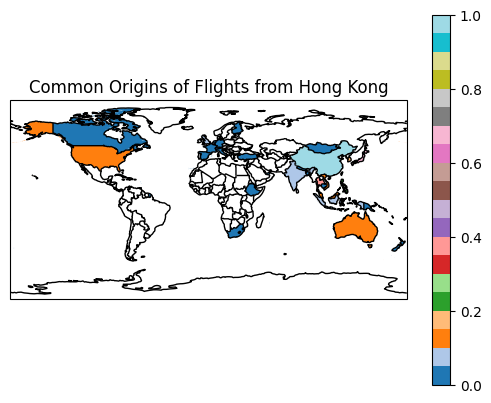

In [142]:
fa = Question2(loop)
await fa.solver1(arrival=True)

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78643d5d8fd0>


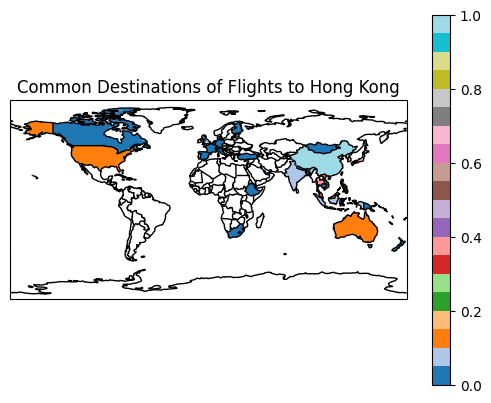

In [145]:
await fa.solver1(arrival=False)

The image below is the scaled up version of the above images generated.

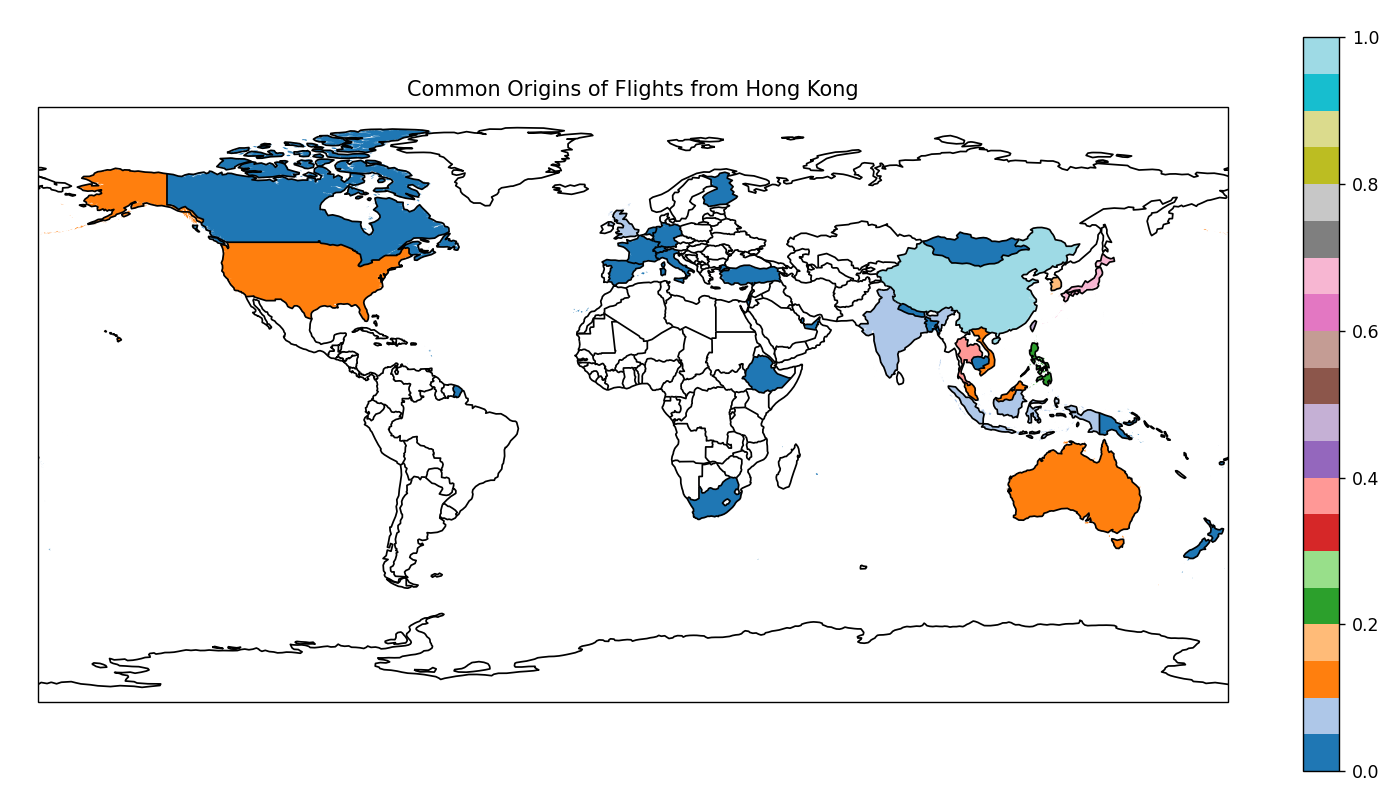

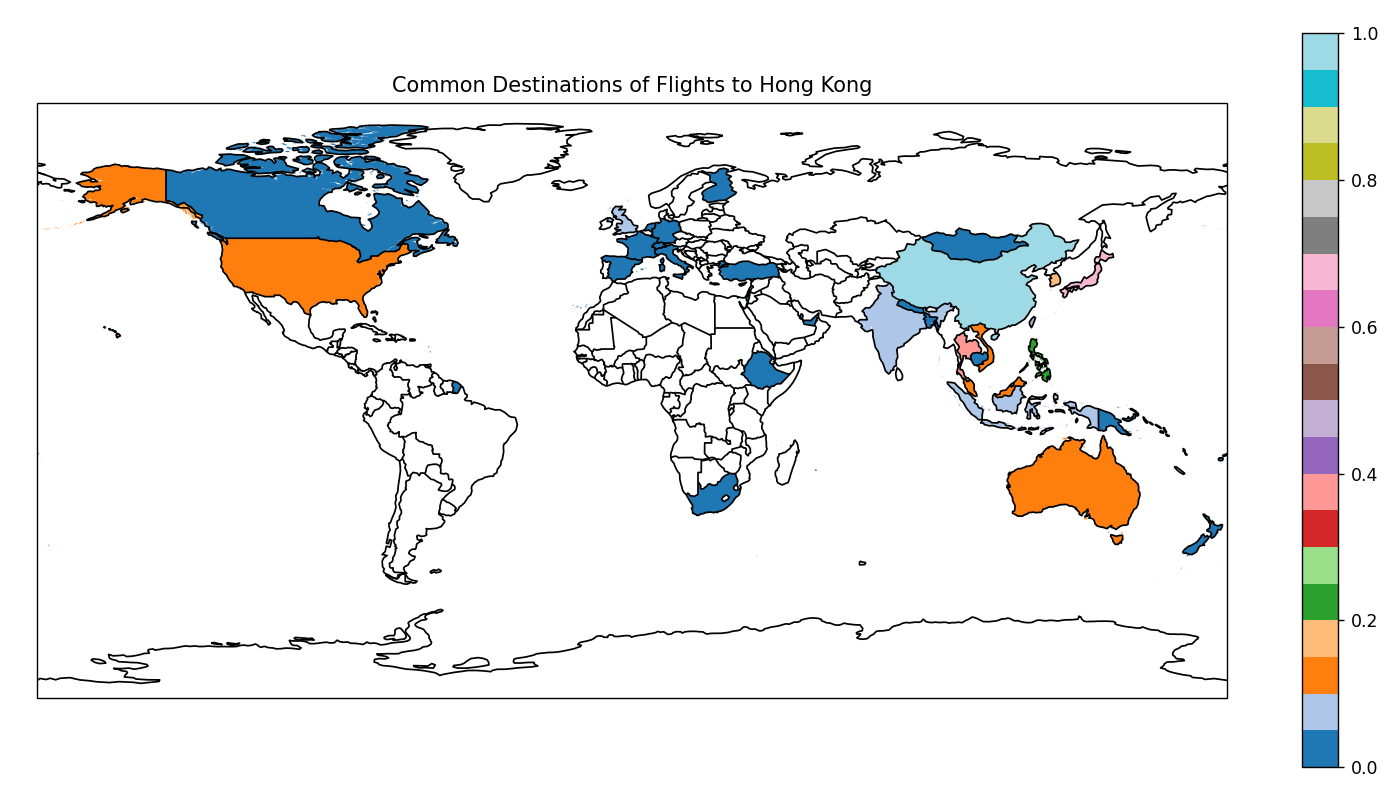

### Mini-conclusion
1. The arrival flights and departure flights gives almost the same result (because a flight is usually a round trip, i.e.: it departs at Hong Kong to another destination and come back to Hong Kong).
2. The most common flights are from/to China, which is in our expectation because most common origin of visitors of Hong Kong are people from Mainland China.
3. Taiwan and Japan has also a lot of flights (above $0.4$) compare to other countries, possibly because Hongkongers prefer visiting these places.
4. Philippines has a value of $0.2$, higher than most of the countries (most countries lies in the range $[0.0, 0.1)$), which is out of my expectation: Hong Kong tourism doesn't mainly compose of people from Philippines, and it is not a common tourism hotspot in Hong Kong either. This may possibly because of the composition of Hong Kong foreign domestic helpers are mostly from the Phillippines, and so there are demands of flights between Hong Kong and the Phillippines. The demand was larger than tourism to Europe and America destinations.
5. There are almost no flights to South America. However, the question of if there are no flights to South America has to be confirmed with later analysis (since the blue spot appeared actually belongs to France).

## Question 2b: What if we visualize our data using bar charts?
We now have grasped the general idea of common destinations. If we visualize our data with bar charts, we can firmly confirm our conclusions made above.

### Analysis Process
The process is same as the one above. However, we have one more method of grouping: group by continent.

Note: I personally wish to analyse by grouping small regions as well, but due to the fact the mapping of ISO 3166-2 code is impossible without buy the data (though can be scrapped in the internet but somehow this is stealing data), we won't perform the analysis of that here.

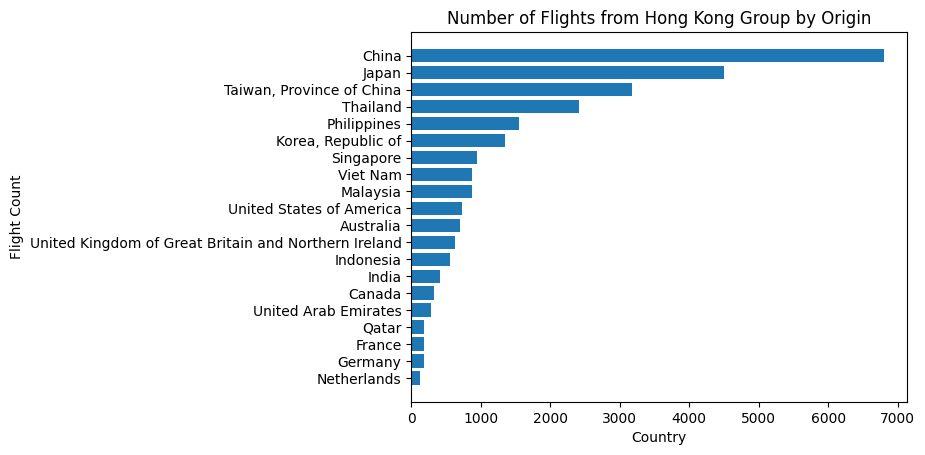

In [39]:
await fa.solver2(arrival=True)

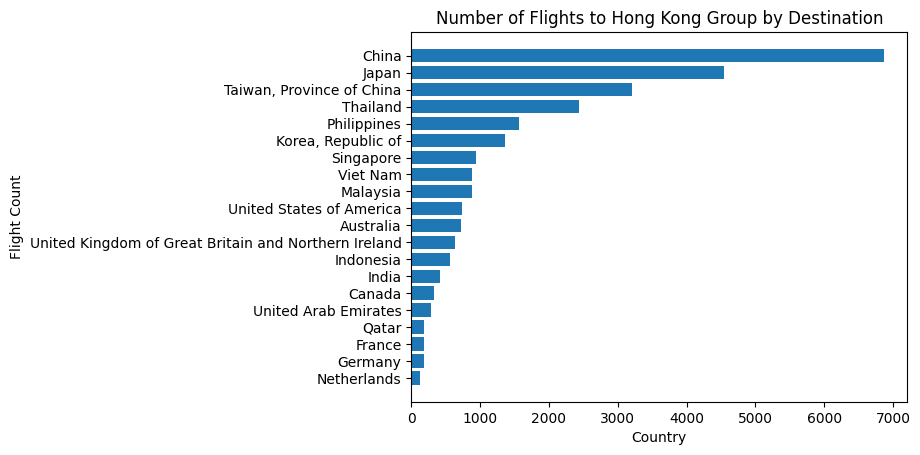

In [40]:
await fa.solver2(arrival=False)

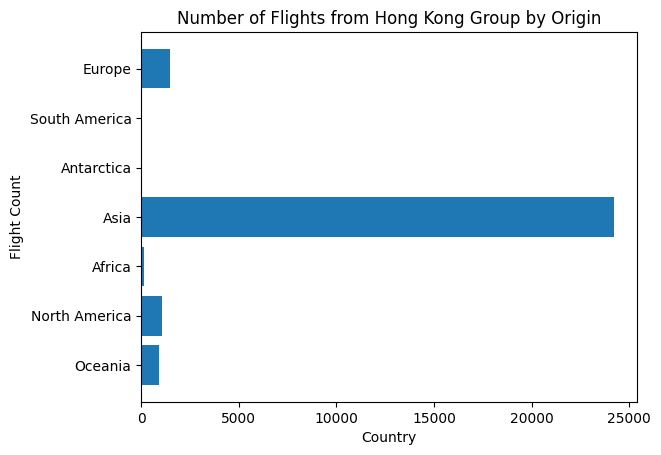

In [44]:
await fa.solver3(arrival=True)

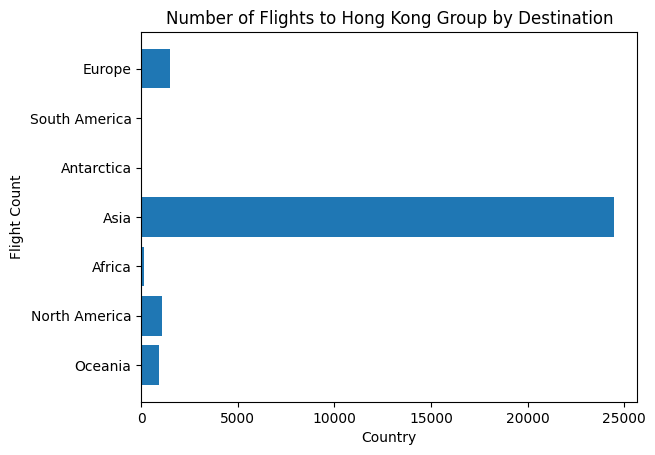

In [45]:
await fa.solver3(arrival=False)

### Mini-conclusion
1. Among all top 20 countries / regions, 13 of them are from Asia (this means Asian countries occupies most of the flights, as shown when flights are being grouped in continents)
2. There are no flights to Antarctica (normal) and South America (a surprising observation!).

## Question 3: Are longer routes generally have a longer delay?
To answer this question, we first have to know how to calculate distance between two spots.

Since we have the latitude and longitude of the airports, we can calculate using the formula suggested by Wikipedia:
$$ d = 2r \arcsin \left (\sqrt{\sin^2 \left(\frac{\varphi_2 - \varphi_1}{2}\right) + \cos \varphi_1 \cdot \cos \varphi_2 \cdot \sin^2 \left(\frac{\lambda_2 - \lambda_1}{2} \right)} \right) $$
Where $r$ is the radius of the sphere (in this case the Earth).

It doesn't matter if we understand the formula or not, cuz neither do I :)

So after using this, let's plot a scatter plot and see the result.

In [59]:
class Question3(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver(self, interval: int = 90, arrival: bool = True):
        import matplotlib.pyplot as plt

        airport_info = await self.client.fetch_airport_info()

        hkg = airport_info["HKG"]

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        dists = []
        delays = []
        for flight in flights:
            target_airport = airport_info[flight.airports[0]]
            # Only consider the FIRST destination
            dist = self.calculate_distance(target_airport["coordinates"] if arrival else hkg["coordinates"], hkg["coordinates"] if arrival else target_airport["coordinates"])
            delay = int((datetime.fromisoformat(flight.act_time) - datetime.fromisoformat(flight.est_time)).total_seconds() // 60)

            if delay >= 300:
                dists.append(dist)
                delays.append(delay)

        plt.scatter(dists, delays)
        plt.title("Scatter Plot of Delays Against Distance")
        plt.xlabel("Distance (in kilometers)")
        plt.ylabel("Delay (in minutes)")

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7864341be0b0>


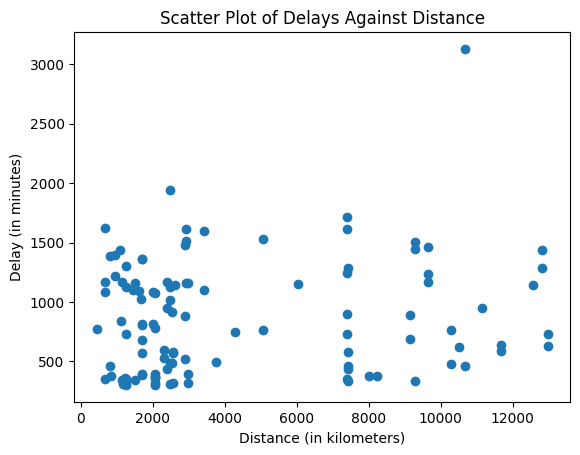

In [133]:
fa = Question3(loop)
await fa.solver(arrival=True)

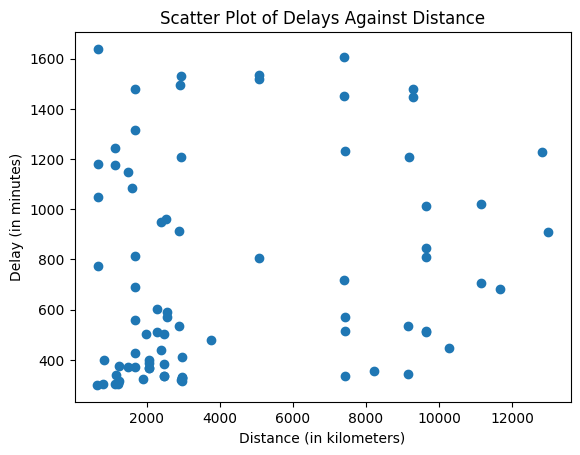

In [134]:
await fa.solver(arrival=False)

### Mini-conclusion
There are no relationships between delays and distance.

## Question 4: Will flights that are scheduled to be arrived / departed at night have a longer delay?
We will plot the estimated arrival time (ignore date, only consider clock time) as x-axis and delay (in minutes) as y-axis.

In [137]:
class Question4(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver(self, interval: int = 90, arrival: bool = True):
        import matplotlib.pyplot as plt

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        times = []
        delays = []
        for flight in flights:
            est_time = datetime.fromisoformat(flight.est_time)
            clock = est_time.time()
            time_from_zero = clock.hour * 3600 + clock.minute * 60 + clock.second
            delay = int((datetime.fromisoformat(flight.act_time) - datetime.fromisoformat(flight.est_time)).total_seconds() // 60)

            if delay >= 300:
                times.append(time_from_zero)
                delays.append(delay)

        plt.scatter(times, delays)
        plt.title(f"Scatter Plot of the Estimated {'Arrival' if arrival else 'Departure'} Against Delay")
        plt.xlabel(f"Estimated {'Arrival' if arrival else 'Departure'} Time Away from 00:00 (in minutes)")
        plt.ylabel("Delays (in minutes)")

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x786435cd1870>


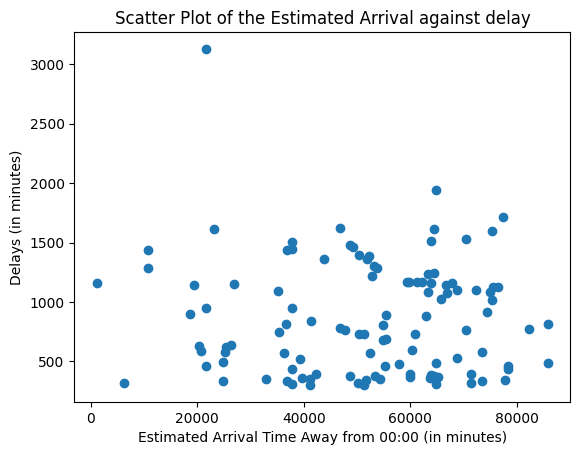

In [135]:
fa = Question4(loop)
await fa.solver(arrival=True)

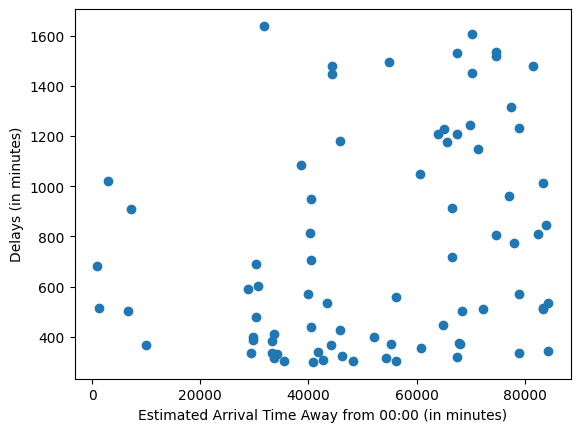

In [63]:
await fa.solver(arrival=False)

## Mini-conclusion
It doesn't matter. Delays can happen at anytime in a day.

## Question 5: Do longer routes have generally less flights?
We will now plot a histogram with distance as x-axis and flight count as y-axis.

In [67]:
class Question5(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver(self, interval: int = 90, arrival: bool = True):
        import matplotlib.pyplot as plt
        import numpy as np

        airport_info = await self.client.fetch_airport_info()

        hkg = airport_info["HKG"]

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        dists = []
        for flight in flights:
            target_airport = airport_info[flight.airports[0]]
            # Only consider the FIRST destination
            dist = self.calculate_distance(target_airport["coordinates"] if arrival else hkg["coordinates"], hkg["coordinates"] if arrival else target_airport["coordinates"])
            dists.append(dist)

        counts, bins = np.histogram(dists, list(range(0, 20000, 2000)))
        plt.hist(bins[:-1], bins, weights=counts)

        plt.title("Number of Flights Binned By Distance")
        plt.xlabel("Distance (in kilometers)")
        plt.ylabel("Flight Count")

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x78643cc00d90>


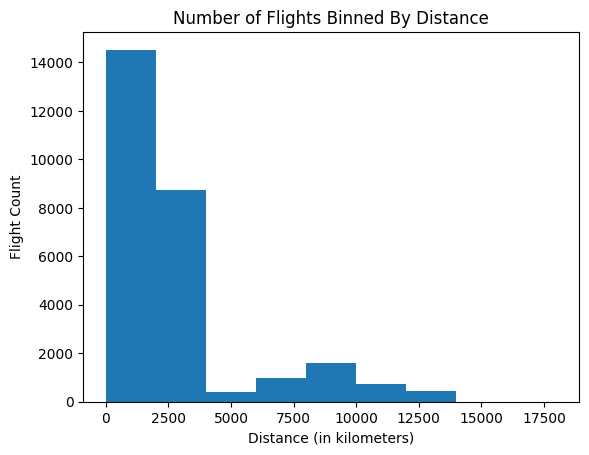

In [69]:
fa = Question5(loop)
await fa.solver(arrival=True)

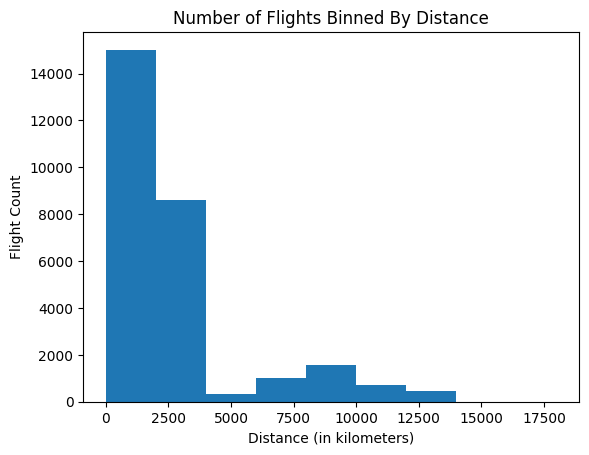

In [70]:
await fa.solver(arrival=False)

## Mini-conclusion
The assumption is partially true: there are more shorter flights than longer flights, but it doesn't strictly decrease as the distance increases.

## Question 6: What are the flight frequency in a day?
We will now investigate the period of the flights. We only consider the estimated time (i.e.: scheduled time). For the sake of the project, we only investigate the flight frequency of the arrival flights.

In [128]:
class Question6(FlightAnalyser):
    def __init__(self, loop):
        super().__init__(loop)

    async def solver1(self, interval: int = 90, arrival: bool = True):
        import matplotlib.pyplot as plt

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        timeslots = [0] * 24 * interval

        for flight in flights:
            est_time = datetime.fromisoformat(flight.est_time)

            hour = est_time.hour
            day = interval - (self.fixed_date.date() - est_time.date()).days - 1
            timeslots[day * 24 + hour] += 1

        plt.plot(list(range(24 * interval)), timeslots)

        plt.title(f"Frequency of Flights Over the Past {interval} Days")
        plt.xlabel(f"Timeslot (Delta hour from {(self.fixed_date.date() - timedelta(days=interval - 1)).isoformat()} 00:00)")
        plt.ylabel("Flight Count")

    async def solver2(self, interval: int = 90, arrival: bool = True):
        import matplotlib.pyplot as plt
        import numpy as np

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        timeslots = [0] * 24 * interval

        for flight in flights:
            est_time = datetime.fromisoformat(flight.act_time)

            hour = est_time.hour
            day = interval - (self.fixed_date.date() - est_time.date()).days - 1
            timeslots[day * 24 + hour] += 1

        x = list(range(24))
        y = [sum([timeslots[i] for i in range(x, 24 * interval, 24)]) / interval for x in range(24)]
        plt.plot(x, y, label="actual data")

        mymodel = np.poly1d(np.polyfit(x, y, 12))
        myline = np.linspace(0, 23, 100)
        plt.plot(myline, mymodel(myline), color="red", label="estimated curve")

        plt.title("Polynomial Regression Against the Data")
        plt.xlabel(f"Timeslot (Delta hour from 00:00)")
        plt.ylabel("Flight Count")
        plt.legend(loc="upper left")

    async def solver3(self, interval: int = 90, arrival: bool = True, skip_date: str = "2023-08-17"):
        import matplotlib.pyplot as plt
        import numpy as np
        import pandas as pd

        flights = await self.fetch_arrival(interval) if arrival else await self.fetch_departure(interval)

        timeslots = [0] * 24 * interval

        actual_data = [0] * 24
        for flight in flights:
            est_time = datetime.fromisoformat(flight.act_time)
            hour = est_time.hour

            # Check if skipping date is needed
            if datetime.fromisoformat(flight.act_time).date().isoformat() == skip_date:
                # SKIP THE DATE
                actual_data[hour] += 1
            else:
                day = interval - (self.fixed_date.date() - est_time.date()).days - 1
                timeslots[day * 24 + hour] += 1

        x = list(range(24))
        y = [sum([timeslots[i] for i in range(x, 24 * interval, 24)]) / (interval - 1) for x in range(24)]

        plt.bar(x, actual_data, label="acutal data")

        plt.title(f"Approximate Data of a Day with Polynomial Regression by Skipping Date {skip_date}")
        plt.xlabel(f"Timeslot (Delta hour from 00:00)")
        plt.ylabel("Flight Count")

        mymodel = np.poly1d(np.polyfit(x, y, 12))
        myline = np.linspace(0, 23, 24)

        estimated_data = list(map(round, mymodel(myline)))
        error = [estimated_data[x] - actual_data[x] for x in range(24)]

        plt.plot(myline, estimated_data, color="red", label="estimated data")

        plt.legend(loc="upper left")

        df = pd.DataFrame(
            {
                "Estimated Data" : estimated_data,
                "Actual Data" : actual_data,
                "Error" : error
            }
        )
        print(df)
        print(f"Average Error: {sum(error) / len(error)}")

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x786434b9a830>


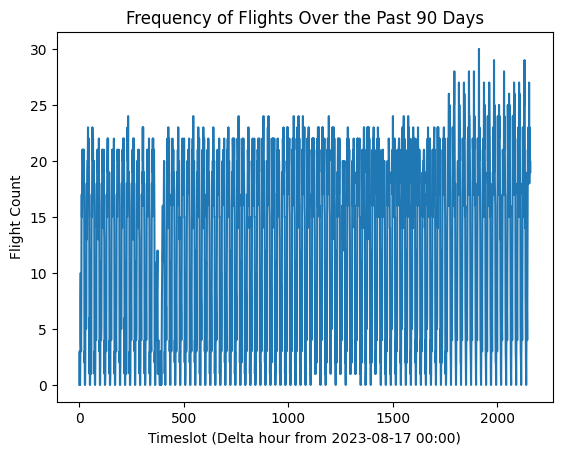

In [129]:
fa = Question6(loop)
await fa.solver1(arrival=True)

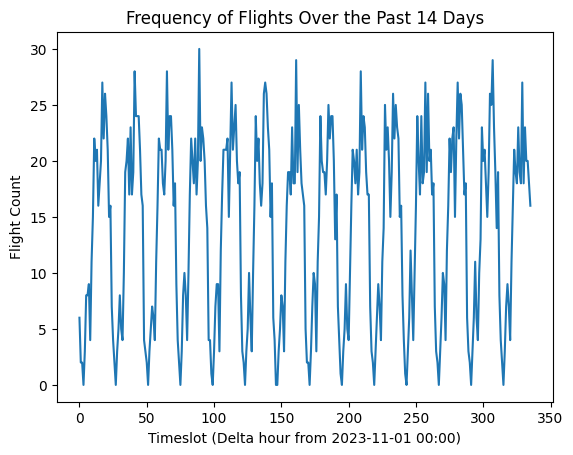

In [90]:
await fa.solver1(interval=14, arrival=True)

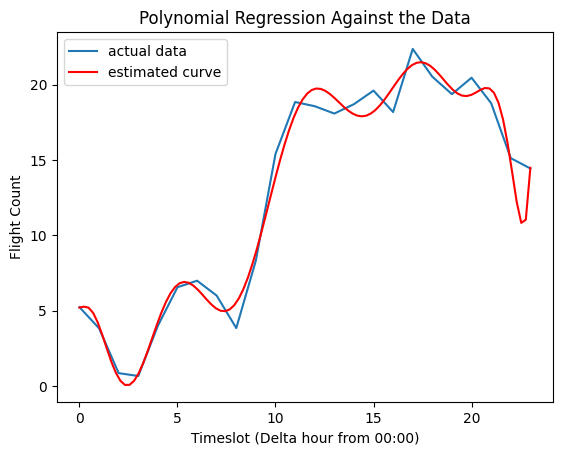

In [122]:
await fa.solver2(arrival=True)

## Mini-conclusion
1. There exists a period for the scheduled flights. There is a trend that there are fewer flights at midnight and more flights in the afternoon and evening. With this in mind, we can estimate number of flights scheduled in a day even when the data is missing.
2. We can also see the trend of the fact that flights over a day has a sudden increase in November (compare the front bit and the later bit of the flights). This indicates that there are more flights coming / leaving Hong Kong, which indicates the revive of aviation industry in Hong Kong. We can guess that this trend will continue (i.e.: there are more flights per day in 2024 than in 2023).



### Method
1. We can plot the average number of flights that arrive at a specific hour (i.e.: find the average of flight count that arrives / departs at 1pm).
2. We then perform polynomial regression of the curve (this time we have polynomial with degree $12$)
3. Use the polynomial to obtain the approximate number of flights in a day.

Let's test with some random dates: let's take `2023-08-17`, `2023-09-10`, `2023-10-21` and `2023-11-01`.

    Estimated Data  Actual Data  Error
0                5            5      0
1                4            3      1
2                1            1      0
3                1            0      1
4                4            6     -2
5                7            5      2
6                6            5      1
7                5            8     -3
8                6            3      3
9                9            8      1
10              14           17     -3
11              18           13      5
12              20           17      3
13              19           20     -1
14              18           16      2
15              18           24     -6
16              20           19      1
17              21           18      3
18              21           19      2
19              20           23     -3
20              19           18      1
21              20           21     -1
22              15           15      0
23              14           16     -2
Average Error: 0.20833333

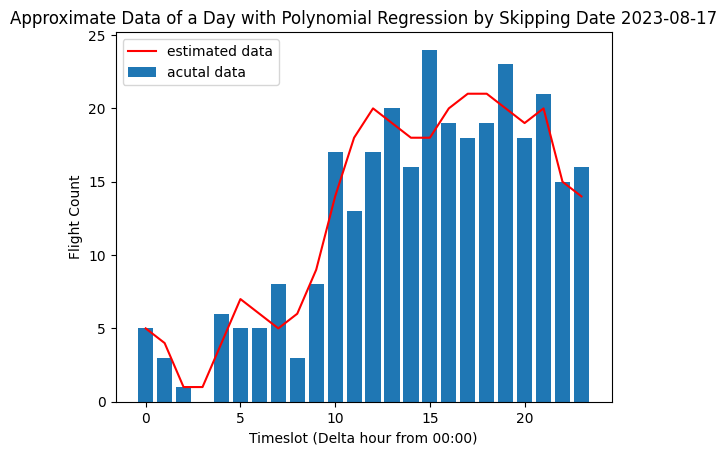

In [130]:
await fa.solver3(arrival=True, skip_date="2023-08-17")

    Estimated Data  Actual Data  Error
0                5            2      3
1                4            3      1
2                1            1      0
3                1            1      0
4                4            4      0
5                7            7      0
6                6            7     -1
7                5            4      1
8                6            6      0
9                9            9      0
10              14           17     -3
11              18           17      1
12              20           17      3
13              19           17      2
14              18           14      4
15              18           22     -4
16              20           22     -2
17              21           25     -4
18              21           17      4
19              20           11      9
20              19           24     -5
21              20           18      2
22              15           18     -3
23              14           15     -1
Average Error: 0.29166666

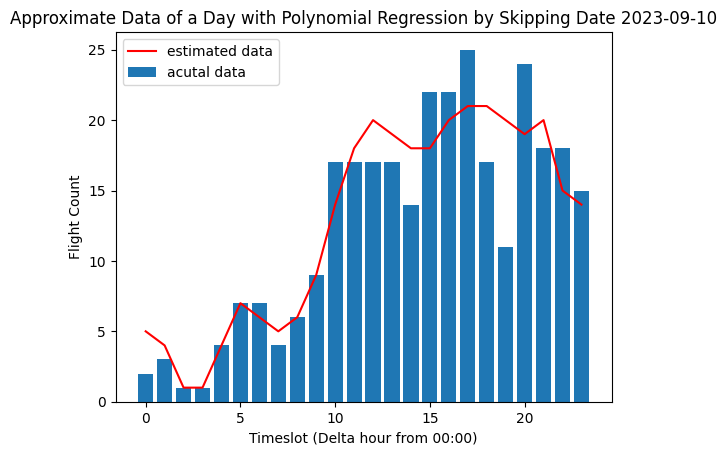

In [131]:
await fa.solver3(arrival=True, skip_date="2023-09-10")

    Estimated Data  Actual Data  Error
0                5            3      2
1                4            7     -3
2                1            2     -1
3                1            1      0
4                4            3      1
5                7            7      0
6                6            8     -2
7                5            7     -2
8                6            4      2
9                9            7      2
10              14           14      0
11              18           18      0
12              20           20      0
13              19           17      2
14              18           26     -8
15              18           16      2
16              20           24     -4
17              21           18      3
18              21           25     -4
19              20           16      4
20              19           19      0
21              20           21     -1
22              15           16     -1
23              14           13      1
Average Error: -0.2916666

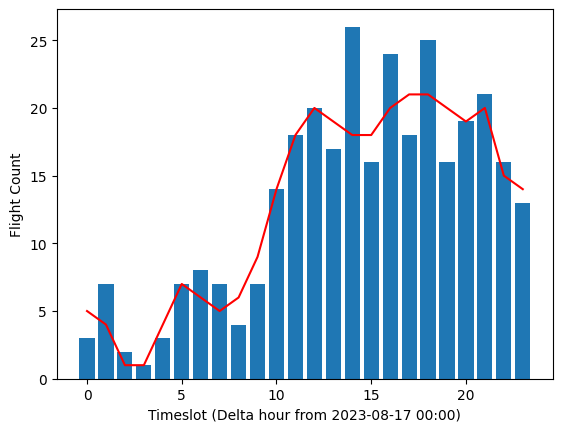

In [95]:
await fa.solver3(arrival=True, skip_date="2023-10-21")

    Estimated Data  Actual Data  Error
0                5            7     -2
1                4            2      2
2                1            3     -2
3                1            0      1
4                4            4      0
5                7            8     -1
6                6            7     -1
7                5            8     -3
8                6            3      3
9                9           13     -4
10              14           16     -2
11              18           20     -2
12              20           19      1
13              19           20     -1
14              18           17      1
15              18           20     -2
16              20           22     -2
17              21           21      0
18              21           26     -5
19              20           28     -8
20              19           22     -3
21              20           20      0
22              15           15      0
23              14           16     -2
Average Error: -1.3333333

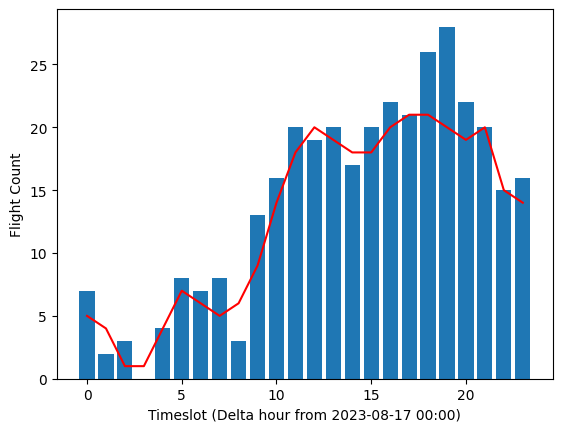

In [96]:
await fa.solver3(arrival=True, skip_date="2023-11-01")

We can see that the average error is low (although it can't handle special case).

## Summary

After all of these investigation, we have investigated a lot of flights information through the data given, for example: common flight destination, flight delays etc. We also have investigate if there are any correlations between distance and delays, time departure / arrival and delays, and between distance and flight count, although all of them have strong correlations.



## Conclusion

1. We can notice that Hong Kong flights are having a normal amount of delays, which is acceptable.
2. We observed that actually we don't have direct flights to a lot of countries (especially we don't have direct flights to South America)
3. We can observe the trend that there are increasing trend in number of Hong Kong arrival / departure flights.

## Reflection
1. We can reflect that Hong Kong aviation industry is reviving from the pandemic
2. We can still see the flaws of the aviation industry in Hong Kong (still have quite some delays, we really need to increase the number of people in aviation industry to possibly minimize the delays).
3. There are huge delays sometimes (there are multiple delays with +300 minutes, which is equal to +5 hours). If we have better aviation systems (aka more advanced), is it possible to minimize these kind of delays?

## Citations
Wikipedia contributors, "Haversine formula," Wikipedia, The Free Encyclopedia, https://en.wikipedia.org/w/index.php?title=Haversine_formula&oldid=1184006468 (accessed December 12, 2023).

Airport Authority Hong Kong, "Flight Information," data.gov.hk, Flight Information, https://data.gov.hk/en-data/dataset/aahk-team1-flight-info (accessed December 12, 2023).

Github contributors, "ip2location-iata-icao," Github, https://github.com/ip2location/ip2location-iata-icao/blob/master/iata-icao.csv
https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv (accessed December 12, 2023).

Github contributors, "ISO-3166-Countries-with-Regional-Codes," Github, https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv (accessed December 12, 2023).